In [10]:
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import sklearn.preprocessing as skp
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.manifold import Isomap

import matplotlib
import warnings
def rcparams(r=1):
    matplotlib.rcParams['font.family'] = 'sans-serif'
    matplotlib.rcParams['font.size'] = 25 * r
    matplotlib.rcParams['xtick.labelsize'] = 20 * r
    matplotlib.rcParams['ytick.labelsize'] = 20 * r
    matplotlib.rcParams['axes.labelsize'] = 25 * r
    matplotlib.rcParams['legend.title_fontsize'] = 17 * r
    matplotlib.rcParams['legend.fontsize'] = 17 * r
    matplotlib.rcParams['axes.axisbelow'] = True
    matplotlib.rcParams['figure.figsize'] = [6 * r, 6 * r]


# format axis
def format_axis(ax):
    from matplotlib.ticker import (AutoMinorLocator)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=3)
    ax.locator_params(axis='x', nbins=5)
    ax.locator_params(axis='y', nbins=5)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.5)
        
def format_axis_im(ax):
    from matplotlib.ticker import (AutoMinorLocator)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=0)
#     ax.locator_params(axis='x', nbins=5)
#     ax.locator_params(axis='y', nbins=5)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.5)

### load data

In [11]:
def generate_data(x, u, window=96):
    n = x.shape[-1] - window
    x = np.array([x[..., i: i + window] for i in range(n)])
    u = np.array([u[..., i: i + window] for i in range(n)])
    return x, u

### load data function
- 365 days, 24 hours, recorded every hour
- pick a window size of 96, 4 days
- holiday=True, if we want to include holiday info

In [12]:
def load_data(window=96, holiday=True):
    # path to the csv file
    path = r'C:\Users\buing\Documents\school research things\topological data project\dmd\Hourly_data_of_Beijing_from_Jinxi_interpolated.csv'
    
    df = pd.read_csv(path)
    
    # Holiday includes weekend, weekday, holiday
    if holiday:
        keys = ['Holiday', 'ERA5_d2m', 'ERA5_t2m', 'ERA5_rh', 'ERA5_sp', 'ERA5_u10', 'ERA5_v10', 'ERA5_blh', 'SO2', 'PM2.5', 'PM10', 'CO', 'NO2', 'O3']
    else:
        keys = ['ERA5_d2m', 'ERA5_t2m', 'ERA5_rh', 'ERA5_sp', 'ERA5_u10', 'ERA5_v10', 'ERA5_blh', 'SO2', 'PM2.5', 'PM10', 'CO', 'NO2', 'O3']
    
    # we have 34 uniques sites
    sites = df['Site'].values
    unique_sites = np.unique(sites)
    # each site has data of 14 * 8760, first 12 are control variables, last 2 are labels
    x = []
    for unique_site in unique_sites:
        ind = sites == unique_site
        df_temp = df[keys].iloc[ind].interpolate().copy()
        if holiday:
            df_holiday = skp.OneHotEncoder().fit_transform(df_temp.Holiday.values.reshape(-1, 1)).toarray()
            df_rest = df_temp.values[:, 1:].astype('float')
            df_temp = np.concatenate((df_holiday, df_rest), axis=1)
        x.append(skp.MinMaxScaler().fit_transform(df_temp))
    x = np.array(x).transpose((2, 0, 1))
    
    # u is control, x is label
    # -6 mean to the last sixth element
    u = x[:-6, :] # --> :-6, from the first element to the last sixth
    
    x = x[-6:, :] # --> -6:, the last six elements
    
    x, u = generate_data(x, u, window)
    
    x = np.concatenate([x[:, :, i, :] for i in range(x.shape[2])], axis=1)
    u = np.concatenate([u[:, :, i, :] for i in range(u.shape[2])], axis=1)
    return x, u, unique_sites

### load data for correlation analysis

only for analyzing the stats of the data, doesn't have rolling windows

In [13]:
def load_data_corr(window=96, holiday=True):
    path = r'C:\Users\buing\Documents\school research things\topological data project\dmd\Hourly_data_of_Beijing_from_Jinxi_interpolated.csv'
    df = pd.read_csv(path)
    if holiday:
        keys = ['Holiday', 'ERA5_d2m', 'ERA5_t2m', 'ERA5_rh', 'ERA5_sp', 'ERA5_u10', 'ERA5_v10', 'ERA5_blh', 'SO2', 'PM2.5', 'PM10', 'CO', 'NO2', 'O3']
    else:
        keys = ['ERA5_d2m', 'ERA5_t2m', 'ERA5_rh', 'ERA5_sp', 'ERA5_u10', 'ERA5_v10', 'ERA5_blh', 'SO2', 'PM2.5', 'PM10', 'CO', 'NO2', 'O3']
    # we have 34 uniques sites
    # rural area, downton and suburban
    sites = df['Site'].values
    unique_sites = np.unique(sites)
    
    # each site has data of 20 * 8760, first 12 are control variables, last 6 are labels
    x = []
    for unique_site in unique_sites:
        ind = sites == unique_site
        df_temp = df[keys].iloc[ind].interpolate().copy()
        if holiday:
            df_holiday = skp.OneHotEncoder().fit_transform(df_temp.Holiday.values.reshape(-1, 1)).toarray()
            df_rest = df_temp.values[:, 1:].astype('float')
            df_temp = np.concatenate((df_holiday, df_rest), axis=1)
        x.append(skp.MinMaxScaler().fit_transform(df_temp))
    x = np.array(x).transpose((2, 0, 1))
    
    # u is control, x is label
    u = x[:-6, :]
    x = x[-6:, :]
    
    return x, u, unique_sites

### dmd function

e.g., if you have the trend of so2 for the past 4 days, you want to predict the next hour so2 level

In [30]:
def dmd(x, r):
    embedding = Isomap(n_components = 3)
    x = embedding.fit_transform(x.T).T # --> pca space, check other data representation, isomap, spectral decomposition
    x0 = x[:, :-1]
    x1 = x[:, 1:]
    
    u, s, v = np.linalg.svd(x0, full_matrices = False)
    A_tilde = u[:, : r].conj().T @ x1 @ v[: r, :].conj().T * np.reciprocal(s[: r])
    Phi, Q = np.linalg.eig(A_tilde)
    Psi = x1 @ v[: r, :].conj().T @ np.diag(np.reciprocal(s[: r])) @ Q
    A = Psi @ np.diag(Phi) @ np.linalg.pinv(Psi)
    A = A.real
    
    x_temp = x1[:, 0]
    x_pred = [x_temp]
    
    n = x1.shape[-1]
    for i in range(n):
        x_pred.append(A @ x_temp)
        x_temp = x_pred[i + 1]
    x_pred = np.array(x_pred).T
    x_pred = pca.inverse_transform(x_pred.T).T
    x1 = pca.inverse_transform(x1.T).T
    return x1, x_pred[:, :-1], x_pred[:, -1]

### dmd with control
it has control variables (14 vars)

e.g., if you have the trend of so2, together with the trend of wind speed, rainfall, etc, for the past 4 days, you want to predict the next hour so2 level

In [15]:
def dmdc(x, u, r):
    x0 = x[:, :-1]
    x1 = x[:, 1:]
    u0 = u[:, :-1]
    u1 = u[:, 1:]
    
    nx = x.shape[0]
    
    omega = np.concatenate((x0, u0), axis=0)
    U, S, Vt = np.linalg.svd(omega, full_matrices=True)
    
    U = U[:, :r]
    S = S[:r]
    Vt = Vt[:r, :]
    Ux = U[:nx, :]
    Uu = U[nx:, :]
    
    A = x1 @ Vt.T / S @ Ux.T
    B = x1 @ Vt.T / S @ Uu.T # --> this B matrix gives you hint about the importance of control variables
    
    x_temp = x1[:, 0]
    x_pred = [x_temp]
    
    n = x1.shape[-1]
    for i in range(n):
        x_pred.append(A @ x_temp + B @ u1[:, i])
        x_temp = x_pred[i + 1]
        
    x_pred = np.array(x_pred).T
    return x1, x_pred[:, :-1], x_pred[:, -1], B

### percentage error

In [16]:
def per_error(x, x_dmd):
    x = x.ravel()
    x_dmd = x_dmd.ravel()
    err = mean_squared_error(x, x_dmd) ** 0.5
    return err

In [17]:
x, u, site_name = load_data(window=96, holiday=True)
print(f"x: {x.shape}") # 6 labels * 34 sites
print(f"u: {u.shape}") # 10 vars * 34 sites

x: (8664, 204, 96)
u: (8664, 340, 96)


### location names

In [18]:
downtown = ['FTHY', 'WL', 'XZMB', 'GY', 'WSXG', 'NSH', 'YDMN', 'QM', 'ATZX', 'DS', 'TT', 'NZG', 'DSH']
suburban = ['BBXQ', 'MTG', 'GC', 'YG', 'FS', 'DX', 'YZ', 'TZ']
northwest_rural = ['YQ', 'BDL', 'DL', 'CP']
northeast_rural = ['SY', 'HR', 'MY', 'SK', 'PG', 'DGC']
southwest_rural = ['LLH']
southeast_rural = ['YF', 'YLD']

In [19]:
x, u, site_name = load_data_corr()
x.shape

(6, 34, 8760)

In [20]:
downtown_idx = [np.where(site_name == downtown[i])[0][0] for i in range(len(downtown))]
suburban_idx = [np.where(site_name == suburban[i])[0][0] for i in range(len(suburban))]
northwest_rural_idx = [np.where(site_name == northwest_rural[i])[0][0] for i in range(len(northwest_rural))]
northeast_rural_idx = [np.where(site_name == northeast_rural[i])[0][0] for i in range(len(northeast_rural))]
southwest_rural_idx = [np.where(site_name == southwest_rural[i])[0][0] for i in range(len(southwest_rural))]
southeast_rural_idx = [np.where(site_name == southeast_rural[i])[0][0] for i in range(len(southeast_rural))]

len(downtown_idx), len(suburban_idx), len(northwest_rural_idx), len(northeast_rural_idx), len(southwest_rural_idx), len(southeast_rural_idx)

(13, 8, 4, 6, 1, 2)

### data correlation

In [21]:
contaminants = ['SO2', 'PM2.5', 'PM10', 'CO', 'NO2', 'O3']

In [22]:
# for i in range(len(contaminants)):
#     corr = x[i, ...]
#     corr = corr[site_idx, :]
#     corr = np.corrcoef(corr)
#     fig, ax = plt.subplots()
#     im = ax.matshow(corr, vmax=1, cmap='coolwarm')
#     rect1 = patches.Rectangle((-0.5, -0.5), 13, 13, linewidth=2, edgecolor='r', facecolor='none')
#     rect2 = patches.Rectangle((12.5, 12.5), 8, 8, linewidth=2, edgecolor='r', facecolor='none')
#     rect3 = patches.Rectangle((20.5, 20.5), 4, 4, linewidth=2, edgecolor='r', facecolor='none')
#     rect4 = patches.Rectangle((24.5, 24.5), 6, 6, linewidth=2, edgecolor='r', facecolor='none')
#     rect5 = patches.Rectangle((30.5, 30.5), 1, 1, linewidth=2, edgecolor='r', facecolor='none')
#     rect6 = patches.Rectangle((31.5, 31.5), 2, 2, linewidth=2, edgecolor='r', facecolor='none')
#     ax.add_patch(rect1)
#     ax.add_patch(rect2)
#     ax.add_patch(rect3)
#     ax.add_patch(rect4)
#     ax.add_patch(rect5)
#     ax.add_patch(rect6)
#     ax.set_title(f'{contaminants[i]}', fontsize=15)
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="5%", pad=0.05)
#     plt.colorbar(im, cax=cax)
#     format_axis_im(ax)
#     format_axis(cax)
#     plt.savefig(f'../result/figure/corr_contaminant_{i}.svg', bbox_inches='tight')

FileNotFoundError: [Errno 2] No such file or directory: '../result/figure/corr_site.svg'

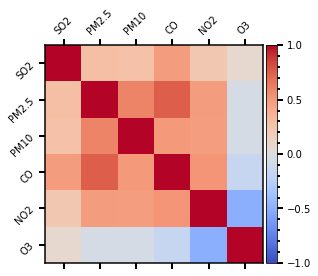

In [23]:
corr = x[:, 4, :]
#corr = corr[site_idx, :]
corr = np.corrcoef(corr)
fig, ax = plt.subplots()
im = ax.matshow(corr, vmin=-1, vmax=1, cmap='coolwarm')
ax.set_xticks(np.arange(6))
ax.set_xticklabels(contaminants, rotation=45)
ax.set_yticks(np.arange(6))
ax.set_yticklabels(contaminants, rotation=45)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
format_axis_im(ax)
format_axis(cax)
plt.savefig(f'../result/figure/corr_site.svg', bbox_inches='tight')

### vanilla dmd
Three DMD reconstructions for SO2 site 1.

In [24]:
x, u, site_name = load_data()
x.shape

(8664, 204, 96)

- r is truncation value
- r < 96
- r = 70, too much truncation, little info left, bad reconstruction
- r = 81, good truncation, good reconstrunction
- r = 90, keep too much info, oscillation, "over-fitting"

ValueError: Found array with dim 3. Estimator expected <= 2.

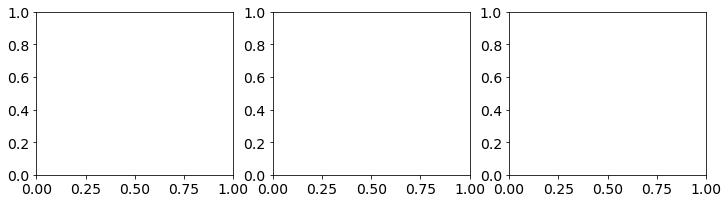

In [31]:
rcparams(0.7)
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))
rs = [70, 86, 90]
for i, r in enumerate(rs):
    x_o, x_r, x_f = dmd(x[1:24*31], r)
    ax[i].plot(x_o[0], 'k--', label='True')
    ax[i].plot(x_r[0], 'r', label='Reconstruction')
    ax[i].set_xticks([0, 24, 48, 72, 96])
    if i == 0:
        ax[i].set_ylabel(f'SO2 {site_name[0]}')
    ax[i].set_ylim([-0.25, 0.55])
    ax[i].set_title(f'r = {r} ({r/95:0.1%})', fontsize=15)
    ax[i].legend()
    ax[i].grid()
    format_axis(ax[i])
plt.savefig(r'C:\Users\buing\Documents\school research things\topological data project\dmd\result\figure\vanilla dmd iso compare\Jan_vanilla_iso_rank.svg', bbox_inches='tight')

### find the optimial truncation value

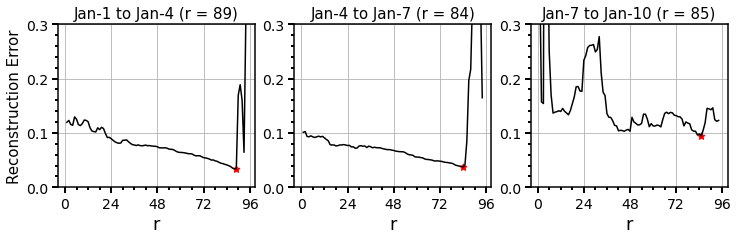

In [18]:
# some time points
ts = [0, 96, 192]

# truncation values
rs = np.arange(1, 95)

titles = ['Jan-1 to Jan-4', 'Jan-4 to Jan-7', 'Jan-7 to Jan-10']

fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

for i, t in enumerate(ts):
    err = []
    for j, r in enumerate(rs):
        x_o, x_r, x_f = dmd(x[t], r)
        err.append(per_error(x_o, x_r))
    ax[i].plot(rs, err, 'k')
    
    idx = np.argmin(err)
    ax[i].scatter(rs[idx], err[idx], marker=(5, 1), c='r', s=50)
    ax[i].set_xticks([0, 24, 48, 72, 96])
    if i == 0:
        ax[i].set_ylabel(f'Reconstruction Error', fontsize=15)
    ax[i].set_xlabel('r')
    ax[i].set_ylim([0, 0.3])
    ax[i].set_title(titles[i]+f' (r = {rs[idx]})', fontsize=15)
    ax[i].grid()
    format_axis(ax[i])
#plt.savefig(f'../result/figure/vanilla_dmd_best_r.svg', bbox_inches='tight')

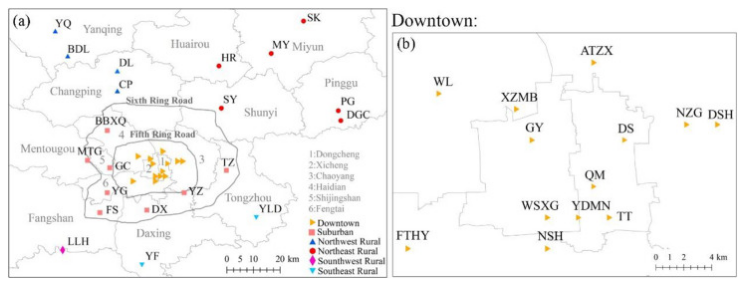

(8664, 204, 96)

In [34]:
from skimage.io import imread
location_map = imread('location.jpeg')
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(location_map)
ax.axis('off')
plt.show()
x.shape

### distribution of errrors

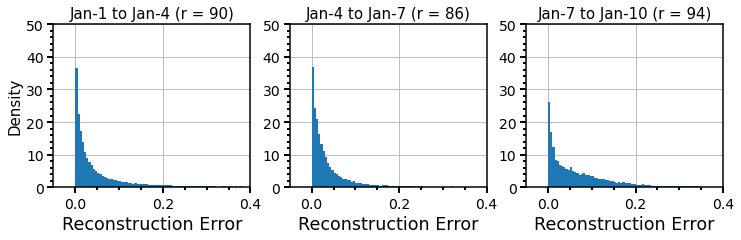

In [20]:
ts = [0, 96, 192]
rs = [90, 86, 94]
titles = ['Jan-1 to Jan-4', 'Jan-4 to Jan-7', 'Jan-7 to Jan-10']
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

for i, t in enumerate(ts):
    x_o, x_r, x_f = dmd(x[t], rs[i])
    x_o = x_o.ravel()
    x_r = x_r.ravel()
    err = [per_error(x_o[j], x_r[j]) for j in range(len(x_o))]
    ax[i].hist(err, bins=np.arange(0, 0.4, 0.005), density=True)
    ax[i].set_xticks([0, 0.2, 0.4])
    if i == 0:
        ax[i].set_ylabel(f'Density', fontsize=15)
    ax[i].set_xlabel('Reconstruction Error')
    ax[i].set_xlim([-0.05, 0.4])
    ax[i].set_ylim([0, 50])
    ax[i].set_title(titles[i]+f' (r = {rs[i]})', fontsize=15)
    ax[i].grid()
    format_axis(ax[i])

### breakdown of error by location

In [ ]:
t = 0
r = 90
titles = ['Jan-1 to Jan-4']
fig, ax = plt.subplots(figsize=(4, 3))

x_o, x_r, x_f = dmd(x[t], r)
err = ((x_o - x_r)**2).mean(axis=1)**0.5
err_site = np.add.reduceat(err, np.arange(0, len(err), 6))
ax.bar(np.arange(13), err_site[downtown_idx], label='downtown')
ax.bar(np.arange(13, 21), err_site[suburban_idx], label='suburban')
ax.bar(np.arange(21, 25), err_site[northwest_rural_idx], label='northwest rural')
ax.bar(np.arange(25, 31), err_site[northeast_rural_idx], label='northeast rural')
ax.bar(np.arange(31, 32), err_site[southwest_rural_idx], label='southwest rural')
ax.bar(np.arange(32, 34), err_site[southeast_rural_idx], label='southeast rural')
ax.set_ylabel('Reconstruction Error', fontsize=15)
ax.set_xlabel('Sites')
ax.set_title(titles[0]+f' (r = {r})', fontsize=15)
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
format_axis(ax)
x[0]

### all month reconstruction error
# now on june


In [5]:
r = 90
err_all = []
err_for = []

for t in range(1,24*31): #Dec
    x_o, x_r, x_f = dmd(x[t], r)
    x_f_ture = x[t+1][:, -1]
    err = ((x_o - x_r)**2).mean(axis=1)**0.5
    err_f = ((x_f - x_f_ture)**2)**0.5
    err_all.append(np.add.reduceat(err, np.arange(0, len(err), 6)) / 34)
    err_for.append(np.add.reduceat(err_f, np.arange(0, len(err_f), 6)) / 34)
    print(f'{t}', end='\r')

err_site = np.array(err_all).mean(axis=0)
err_site_std = np.array(err_all).std(axis=0)

err_for = np.array(err_for).mean(axis=0)


NameError: name 'x' is not defined

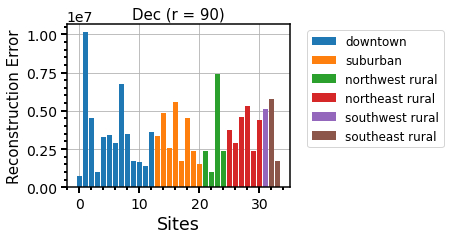

In [46]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.bar(np.arange(13), err_site[downtown_idx], label='downtown')
ax.bar(np.arange(13, 21), err_site[suburban_idx], label='suburban')
ax.bar(np.arange(21, 25), err_site[northwest_rural_idx], label='northwest rural')
ax.bar(np.arange(25, 31), err_site[northeast_rural_idx], label='northeast rural')
ax.bar(np.arange(31, 32), err_site[southwest_rural_idx], label='southwest rural')
ax.bar(np.arange(32, 34), err_site[southeast_rural_idx], label='southeast rural')
ax.set_ylabel('Reconstruction Error', fontsize=15)
ax.set_xlabel('Sites')
ax.set_title(f'Dec (r = {r})', fontsize=15)
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
format_axis(ax)
plt.savefig(r'C:\Users\buing\Documents\school research things\topological data project\dmd\result\figure\err_reconstruct\vanilla_dmd_dec3_reconst_pca.svg', bbox_inches='tight')

### forcasting error
- previously, we reconstruct the known trend
- now we predict the next hour trend

75

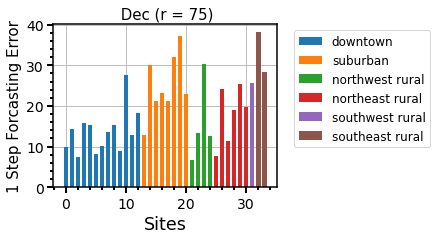

In [44]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.bar(np.arange(13), err_for[downtown_idx], label='downtown')
ax.bar(np.arange(13, 21), err_for[suburban_idx], label='suburban')
ax.bar(np.arange(21, 25), err_for[northwest_rural_idx], label='northwest rural')
ax.bar(np.arange(25, 31), err_for[northeast_rural_idx], label='northeast rural')
ax.bar(np.arange(31, 32), err_for[southwest_rural_idx], label='southwest rural')
ax.bar(np.arange(32, 34), err_for[southeast_rural_idx], label='southeast rural')
ax.set_ylabel('1 Step Forcasting Error', fontsize=15)
ax.set_xlabel('Sites')
ax.set_title(f' Dec (r = {r})', fontsize=15)
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
format_axis(ax)
plt.savefig(r'C:\Users\buing\Documents\school research things\topological data project\dmd\result\figure\err_forecast\vanilla_dmd_dec3_forcast_pca.svg', bbox_inches='tight')
r

### dmdc

In [ ]:
rcparams(0.7)
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))
rs = [1, 60, 85]
for i, r in enumerate(rs):
    x_o, x_r, x_f, B = dmdc(x[24*31+24*28+24*31+24*30+24*31+24*30], u[24*31+24*28+24*31+24*30+24*31+24*30], r)
    ax[i].plot(x_o[0], 'k--', label='True')
    ax[i].plot(x_r[0], 'r', label='Reconstruction')
    ax[i].set_xticks([0, 24, 48, 72, 96])
    if i == 0:
        ax[i].set_ylabel(f'SO2 {site_name[0]}')
    ax[i].set_ylim([-0.25, 0.55])
    ax[i].set_title(f'r = {r} ({r/95:0.1%})', fontsize=15)
    ax[i].legend()
    ax[i].grid()
    format_axis(ax[i])
plt.savefig(r'C:\Users\buing\Documents\school research things\topological data project\dmd\result\figure\rank_compare\dmdc_rank_feb.svg', bbox_inches='tight')
x.shape

In [ ]:
ts = [0, 96, 192]
rs = np.arange(1, 95)
titles = ['Jan-1 to Jan-4', 'Jan-4 to Jan-7', 'Jan-7 to Jan-10']
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

for i, t in enumerate(ts):
    err = []
    for j, r in enumerate(rs):
        x_o, x_r, x_f, B = dmdc(x[t], u[t], r)
        err.append(per_error(x_o, x_r))
    ax[i].plot(rs, err, 'k')
    
    idx = np.argmin(err)
    ax[i].scatter(rs[idx], err[idx], marker=(5, 1), c='r', s=50)
    ax[i].set_xticks([0, 24, 48, 72, 96])
    if i == 0:
        ax[i].set_ylabel(f'Reconstruction Error', fontsize=12)
    ax[i].set_xlabel('r')
    ax[i].set_ylim([0, 0.1])
    ax[i].set_title(titles[i]+f' (r = {rs[idx]})', fontsize=15)
    ax[i].grid()
    format_axis(ax[i])
plt.savefig(r'C:\Users\buing\Documents\school research things\topological data project\dmd\result\figure\dmdc_rank_best.svg', bbox_inches='tight')

In [ ]:
t = 0
r = 90
titles = ['Jan-1 to Jan-4']
fig, ax = plt.subplots(figsize=(4, 3))

x_o, x_r, x_f, B = dmdc(x[t], u[t], r)
err = ((x_o - x_r)**2).mean(axis=1)**0.5
err_site = np.add.reduceat(err, np.arange(0, len(err), 6))
ax.bar(np.arange(13), err_site[downtown_idx], label='downtown')
ax.bar(np.arange(13, 21), err_site[suburban_idx], label='suburban')
ax.bar(np.arange(21, 25), err_site[northwest_rural_idx], label='northwest rural')
ax.bar(np.arange(25, 31), err_site[northeast_rural_idx], label='northeast rural')
ax.bar(np.arange(31, 32), err_site[southwest_rural_idx], label='southwest rural')
ax.bar(np.arange(32, 34), err_site[southeast_rural_idx], label='southeast rural')
ax.set_ylabel('Reconstruction Error', fontsize=15)
ax.set_xlabel('Sites')
ax.set_title(titles[0]+f' (r = {r})', fontsize=15)
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
format_axis(ax)

In [ ]:
r = 90
err_all = []
err_for = []
for t in range(24 * 31):
    x_o, x_r, x_f, B = dmdc(x[t], u[t], r)
    x_f_ture = x[t+1][:, -1]
    err = ((x_o - x_r)**2).mean(axis=1)**0.5
    err_f = ((x_f - x_f_ture)**2)**0.5
    err_all.append(np.add.reduceat(err, np.arange(0, len(err), 6)) / 34)
    err_for.append(np.add.reduceat(err_f, np.arange(0, len(err_f), 6)) / 34)
    print(f'{t}', end='\r')
    
err_site = np.array(err_all).mean(axis=0)
err_site_std = np.array(err_all).std(axis=0)

err_for = np.array(err_for).mean(axis=0)

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.bar(np.arange(13), err_site[downtown_idx], label='downtown')
ax.bar(np.arange(13, 21), err_site[suburban_idx], label='suburban')
ax.bar(np.arange(21, 25), err_site[northwest_rural_idx], label='northwest rural')
ax.bar(np.arange(25, 31), err_site[northeast_rural_idx], label='northeast rural')
ax.bar(np.arange(31, 32), err_site[southwest_rural_idx], label='southwest rural')
ax.bar(np.arange(32, 34), err_site[southeast_rural_idx], label='southeast rural')
ax.set_ylabel('Reconstruction Error', fontsize=15)
ax.set_xlabel('Sites')
ax.set_title(f'January (r = {r})', fontsize=15)
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
format_axis(ax)
#plt.savefig(f'../result/figure/dmdc_jan_reconst.svg', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.bar(np.arange(13), err_for[downtown_idx], label='downtown')
ax.bar(np.arange(13, 21), err_for[suburban_idx], label='suburban')
ax.bar(np.arange(21, 25), err_for[northwest_rural_idx], label='northwest rural')
ax.bar(np.arange(25, 31), err_for[northeast_rural_idx], label='northeast rural')
ax.bar(np.arange(31, 32), err_for[southwest_rural_idx], label='southwest rural')
ax.bar(np.arange(32, 34), err_for[southeast_rural_idx], label='southeast rural')
ax.set_ylabel('1 hr Forcasting Error', fontsize=15)
ax.set_xlabel('Sites')
ax.set_title(f'January (r = {r})', fontsize=15)
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
format_axis(ax)
plt.savefig(f'../result/figure/dmdc_jan_forcast.svg', bbox_inches='tight')

In [ ]:
keys = ['Holiday', 'Weekday', 'Weekend', 'Dew point',
         'Temp',
         'RH',
         'Pressure', 
         'U wind', 
         'V wind',
         'BLH']

### dmdc insights

In [ ]:
B_all = B[0, :] # --> contains all importance values
B_all = np.add.reduceat(B_all, np.arange(0, len(B_all), 34))
fig, ax = plt.subplots()
ax.bar(np.arange(10), B_all)
ax.set_ylabel('B value')
ax.set_xticks(np.arange(10))
ax.set_xticklabels(keys, rotation=90)
ax.set_title('SO2', fontsize=15)
ax.grid()
format_axis_im(ax)

In [ ]:
x, u, site_name = load_data(window=96, holiday=False)
print(f"x: {x.shape}")
print(f"u: {u.shape}")

In [ ]:
rcparams(0.7)
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))
rs = [20, 60, 80]
for i, r in enumerate(rs):
    x_o, x_r, x_f, B = dmdc(x[0], u[0], r)
    ax[i].plot(x_o[0], 'k--', label='True')
    ax[i].plot(x_r[0], 'r', label='Reconstruction')
    ax[i].set_xticks([0, 24, 48, 72, 96])
    if i == 0:
        ax[i].set_ylabel(f'SO2 {site_name[0]}')
    ax[i].set_ylim([-0.25, 0.55])
    ax[i].set_title(f'r = {r} ({r/95:0.1%})', fontsize=15)
    ax[i].legend()
    ax[i].grid()
    format_axis(ax[i])

In [ ]:
ts = [0, 96, 192]
rs = np.arange(1, 95)
titles = ['Jan-1 to Jan-4', 'Jan-4 to Jan-7', 'Jan-7 to Jan-10']
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

for i, t in enumerate(ts):
    err = []
    for j, r in enumerate(rs):
        x_o, x_r, x_f, B = dmdc(x[t], u[t], r)
        err.append(per_error(x_o, x_r))
    ax[i].plot(rs, err, 'k')
    
    idx = np.argmin(err)
    ax[i].scatter(rs[idx], err[idx], marker=(5, 1), c='r', s=50)
    ax[i].set_xticks([0, 24, 48, 72, 96])
    if i == 0:
        ax[i].set_ylabel(f'Reconstruction Error', fontsize=12)
    ax[i].set_xlabel('r')
    ax[i].set_ylim([0, 0.1])
    ax[i].set_title(titles[i]+f' (r = {rs[idx]})', fontsize=15)
    ax[i].grid()
    format_axis(ax[i])

In [ ]:
t = 0
r = 94
titles = ['Jan-1 to Jan-4']
fig, ax = plt.subplots(figsize=(4, 3))

x_o, x_r, x_f, B = dmdc(x[t], u[t], r)
err = ((x_o - x_r)**2).mean(axis=1)**0.5
err_site = np.add.reduceat(err, np.arange(0, len(err), 6))
ax.bar(np.arange(13), err_site[downtown_idx], label='downtown')
ax.bar(np.arange(13, 21), err_site[suburban_idx], label='suburban')
ax.bar(np.arange(21, 25), err_site[northwest_rural_idx], label='northwest rural')
ax.bar(np.arange(25, 31), err_site[northeast_rural_idx], label='northeast rural')
ax.bar(np.arange(31, 32), err_site[southwest_rural_idx], label='southwest rural')
ax.bar(np.arange(32, 34), err_site[southeast_rural_idx], label='southeast rural')
ax.set_ylabel('Reconstruction Error', fontsize=15)
ax.set_xlabel('Sites')
ax.set_title(titles[0]+f' (r = {r})', fontsize=15)
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
format_axis(ax)

In [ ]:
r = 90
err_all = []
err_for = []
for t in range(24 * 31):
    x_o, x_r, x_f, B = dmdc(x[t], u[t], r)
    x_f_ture = x[t+1][:, -1]
    err = ((x_o - x_r)**2).mean(axis=1)**0.5
    err_f = ((x_f - x_f_ture)**2)**0.5
    err_all.append(np.add.reduceat(err, np.arange(0, len(err), 6)) / 34)
    err_for.append(np.add.reduceat(err_f, np.arange(0, len(err_f), 6)) / 34)
    print(f'{t}', end='\r')
    
err_site = np.array(err_all).mean(axis=0)
err_site_std = np.array(err_all).std(axis=0)

err_for = np.array(err_for).mean(axis=0)

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.bar(np.arange(13), err_site[downtown_idx], label='downtown')
ax.bar(np.arange(13, 21), err_site[suburban_idx], label='suburban')
ax.bar(np.arange(21, 25), err_site[northwest_rural_idx], label='northwest rural')
ax.bar(np.arange(25, 31), err_site[northeast_rural_idx], label='northeast rural')
ax.bar(np.arange(31, 32), err_site[southwest_rural_idx], label='southwest rural')
ax.bar(np.arange(32, 34), err_site[southeast_rural_idx], label='southeast rural')
ax.set_ylabel('Reconstruction Error', fontsize=15)
ax.set_xlabel('Sites')
ax.set_title(f'January (r = {r})', fontsize=15)
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
format_axis(ax)
plt.savefig(f'../result/figure/dmdc_jan_reconst_noholiday.svg', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.bar(np.arange(13), err_for[downtown_idx], label='downtown')
ax.bar(np.arange(13, 21), err_for[suburban_idx], label='suburban')
ax.bar(np.arange(21, 25), err_for[northwest_rural_idx], label='northwest rural')
ax.bar(np.arange(25, 31), err_for[northeast_rural_idx], label='northeast rural')
ax.bar(np.arange(31, 32), err_for[southwest_rural_idx], label='southwest rural')
ax.bar(np.arange(32, 34), err_for[southeast_rural_idx], label='southeast rural')
ax.set_ylabel('1 hr Forcasting Error', fontsize=15)
ax.set_xlabel('Sites')
ax.set_title(f'January (r = {r})', fontsize=15)
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
format_axis(ax)
plt.savefig(f'../result/figure/dmdc_jan_forcast_noholiday.svg', bbox_inches='tight')

In [ ]:
B_all = B[6, :]
B_all = np.add.reduceat(B_all, np.arange(0, len(B_all), 34))
fig, ax = plt.subplots()
ax.bar(np.arange(7), B_all)
ax.set_ylabel('B value')
ax.set_xticks(np.arange(7))
ax.set_xticklabels(keys[3:], rotation=90)
ax.set_title('Site 2 SO2', fontsize=15)
ax.grid()
format_axis_im(ax)
plt.savefig(f'../result/figure/dmdc_jan_B_noholiday.svg', bbox_inches='tight')

In [ ]:
B_all = np.zeros((238, ))
for i in range(34):
    B_all += B[6*i, :]
B_all = np.add.reduceat(B_all, np.arange(0, len(B_all), 34))
fig, ax = plt.subplots()
ax.bar(np.arange(7), B_all)
ax.set_ylabel('B value')
ax.set_xticks(np.arange(7))
ax.set_xticklabels(keys[3:], rotation=90)
ax.set_title('Site 2 SO2', fontsize=15)
ax.grid()
format_axis_im(ax)
plt.savefig(f'../result/figure/dmdc_jan_B_SO2_noholiday.svg', bbox_inches='tight')

### last section is on clustering effect

In [ ]:
B_corr = B[7, :]
B_corr = np.array([B_corr[i*7 : (i+1)*7] for i in range(34)])
B_corr = B_corr[site_idx, :]
B_corr = np.corrcoef(B_corr)
fig, ax = plt.subplots()
im = ax.matshow(B_corr, vmin=-1, vmax=1, cmap='coolwarm')
rect1 = patches.Rectangle((-0.5, -0.5), 13, 13, linewidth=2, edgecolor='r', facecolor='none')
rect2 = patches.Rectangle((12.5, 12.5), 8, 8, linewidth=2, edgecolor='r', facecolor='none')
rect3 = patches.Rectangle((20.5, 20.5), 4, 4, linewidth=2, edgecolor='r', facecolor='none')
rect4 = patches.Rectangle((24.5, 24.5), 6, 6, linewidth=2, edgecolor='r', facecolor='none')
rect5 = patches.Rectangle((30.5, 30.5), 1, 1, linewidth=2, edgecolor='r', facecolor='none')
rect6 = patches.Rectangle((31.5, 31.5), 2, 2, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)
ax.add_patch(rect4)
ax.add_patch(rect5)
ax.add_patch(rect6)
ax.set_title('Site 2 PM2.5', fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
format_axis_im(ax)
format_axis(cax)
plt.savefig(f'../result/figure/dmdc_jan_B_SO2_corr_noholiday.svg', bbox_inches='tight')

### to-do
- forcasting, reconstrunction for other months
- check other data representation methods, similar to pca

In [ ]:
load_data()